# Импортирование библиотек

In [5]:
#!pip install optuna

In [6]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer



from sklearn.naive_bayes import MultinomialNB #??
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


import optuna
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer



nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Подготовка данных

Подгружаем dataset

In [7]:
from google.colab import drive; drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
path_sentiment = '/content/drive/MyDrive/combined_sentiment_data.csv'

In [9]:
df_sent = pd.read_csv(path_sentiment)

In [10]:
df_sent.head(10)

,sentence,sentiment
0,So there is no way for me to plug it in here i...,negative
1,"Good case, Excellent value.",positive
2,Great for the jawbone.,positive
3,Tied to charger for conversations lasting more...,negative
4,The mic is great.,positive
5,I have to jiggle the plug to get it to line up...,negative
6,If you have several dozen or several hundred c...,negative
7,If you are Razr owner...you must have this!,positive
8,"Needless to say, I wasted my money.",negative
9,What a waste of money and time!.,negative


In [11]:
df_sent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3309 entries, 0 to 3308
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   3309 non-null   object
 1   sentiment  3309 non-null   object
dtypes: object(2)
memory usage: 51.8+ KB


Проверим на наличие пропусков

# EDA

In [12]:
df_sent.isnull().sum()

,0
sentence,0
sentiment,0


Посмотрим статистики по таблице

In [13]:
df_sent.describe()

,sentence,sentiment
count,3309,3309
unique,3289,2
top,#NAME?,positive
freq,4,1679


Давайте удалим не нужные строки

In [14]:
df_sent.duplicated().sum()

19

In [15]:
df_sent.drop(df_sent[df_sent.duplicated()].index, inplace=True)

Посмотрим ближе на целевую переменную

Text(0, 0.5, 'Count')

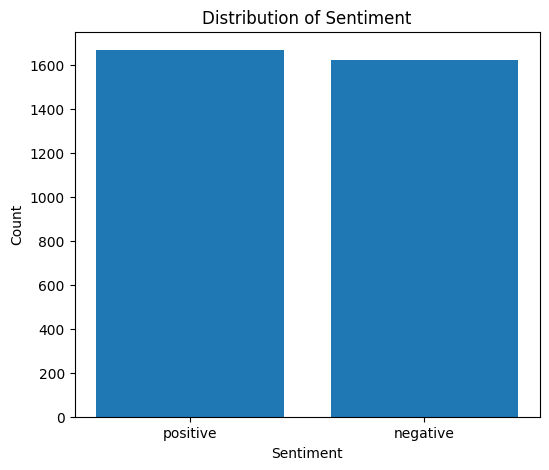

In [16]:
sentiment_counts = df_sent['sentiment'].value_counts()

plt.figure(figsize=(6, 5))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')

Как можно видеть, дисбаланса классов нет

In [17]:
df_sent['sentiment'].value_counts()

,count
sentiment,
positive,1668
negative,1622


Посчитаем длину предложения и посмотрим распределение для каждого класса

In [18]:
def length(text):
    '''a function which returns the length of text'''
    return len(text)

In [19]:
df_sent['length'] = df_sent['sentence'].apply(length)

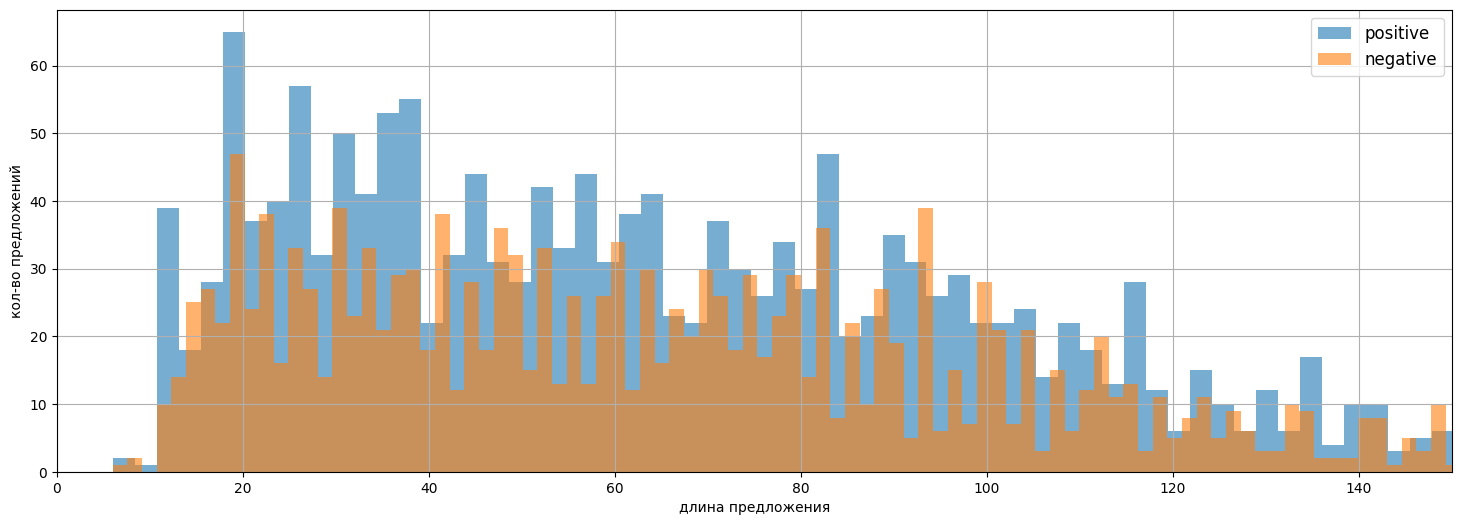

In [20]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.hist(df_sent[df_sent['sentiment'] == 'positive']['length'], alpha = 0.6, bins=200, label='positive')
plt.hist(df_sent[df_sent['sentiment'] == 'negative']['length'], alpha = 0.6, bins=200, label='negative')
plt.xlabel('длина предложения')
plt.ylabel('кол-во предложений')
plt.legend(loc='upper right', fontsize='large')
plt.xlim(0,150)
plt.grid()
plt.show()

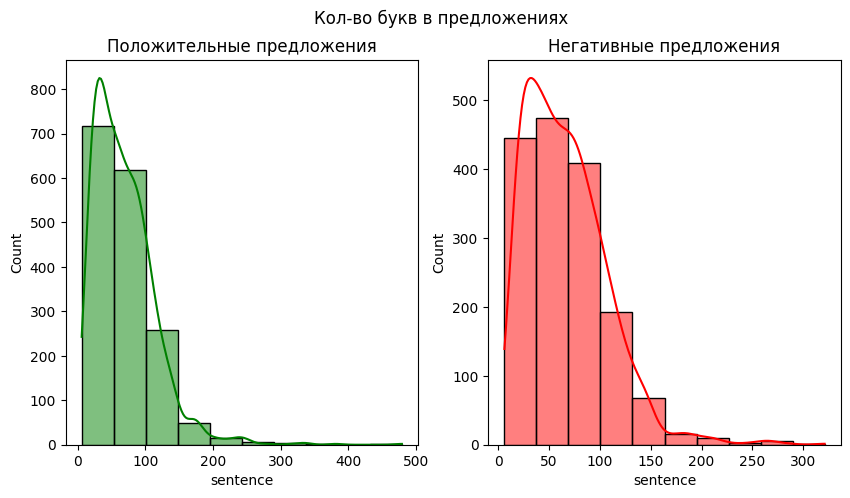

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

sentence_len=df_sent[df_sent['sentiment'] == 'positive']['sentence'].str.len()
sns.histplot(sentence_len, ax=ax1, color='green', bins=10, kde=True)
ax1.set_title('Положительные предложения')

sentence_len2=df_sent[df_sent['sentiment'] == 'negative']['sentence'].str.len()
sns.histplot(sentence_len2, ax=ax2, color='red', bins=10, kde=True)
ax2.set_title('Негативные предложения')

fig.suptitle('Кол-во букв в предложениях')
plt.show()

Можно заметить из двух распределений, что длина предложений с негативной эмоцией содержит больше символов.

Кол-во слов в разерезе двух классов

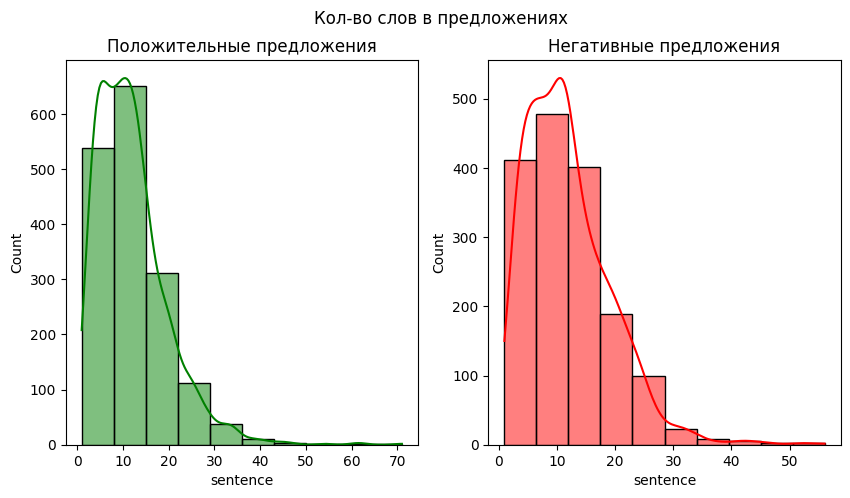

In [22]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

sentence_len=df_sent[df_sent['sentiment'] == 'positive']['sentence'].str.split().map(lambda x: len(x))
sns.histplot(sentence_len, ax=ax1, color='green', bins=10, kde=True)
ax1.set_title('Положительные предложения')

sentence_len2=df_sent[df_sent['sentiment'] == 'negative']['sentence'].str.split().map(lambda x: len(x))
sns.histplot(sentence_len2, ax=ax2, color='red', bins=10, kde=True)
ax2.set_title('Негативные предложения')

fig.suptitle('Кол-во слов в предложениях')
plt.show()

<ipython-input-23-385996b4c815>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word1.map(lambda x: np.mean(x)),ax=ax1,color='blue')
<ipython-input-23-385996b4c815>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word2.map(lambda x: np.mean(x)),ax=ax2,color='red')


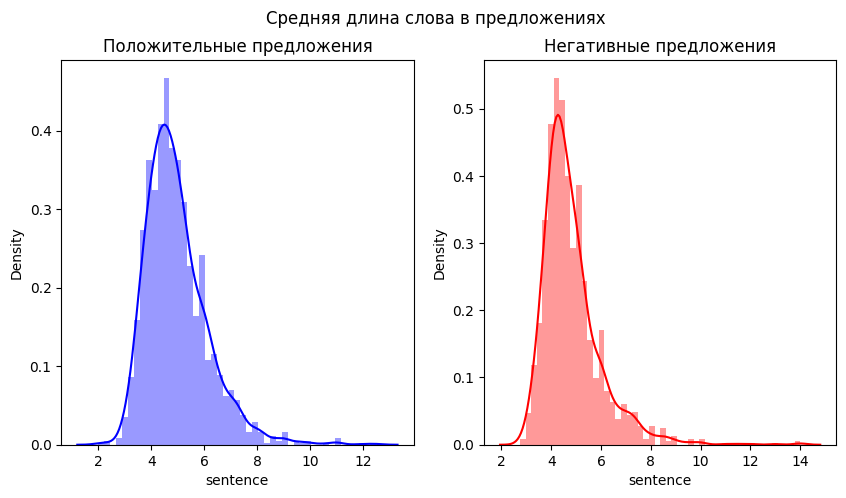

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

word1=df_sent[df_sent['sentiment'] == 'positive']['sentence'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word1.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('Положительные предложения')

word2=df_sent[df_sent['sentiment'] == 'negative']['sentence'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word2.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Негативные предложения')

fig.suptitle('Средняя длина слова в предложениях')
plt.show()

In [24]:
def create_corpus(target):
    corpus=[]

    for x in df_sent[df_sent['sentiment'] == target]['sentence'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [25]:
def create_corpus_df(sentence, target):
    corpus=[]

    for x in df_sent[df_sent['sentiment'] == target]['sentence'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

Проанализируем наличие стоп-слов в предложениях для позитовного класса предложений

In [26]:
stop=set(stopwords.words('english'))

corpus=create_corpus('positive')

dic= {}
for word in corpus:
    if word in stop:
        if word in dic:
            dic[word] += 1
        else:
            dic[word] = 1

top=sorted(dic.items(), key=lambda x:x[0],reverse=True)[:15]

<BarContainer object of 15 artists>

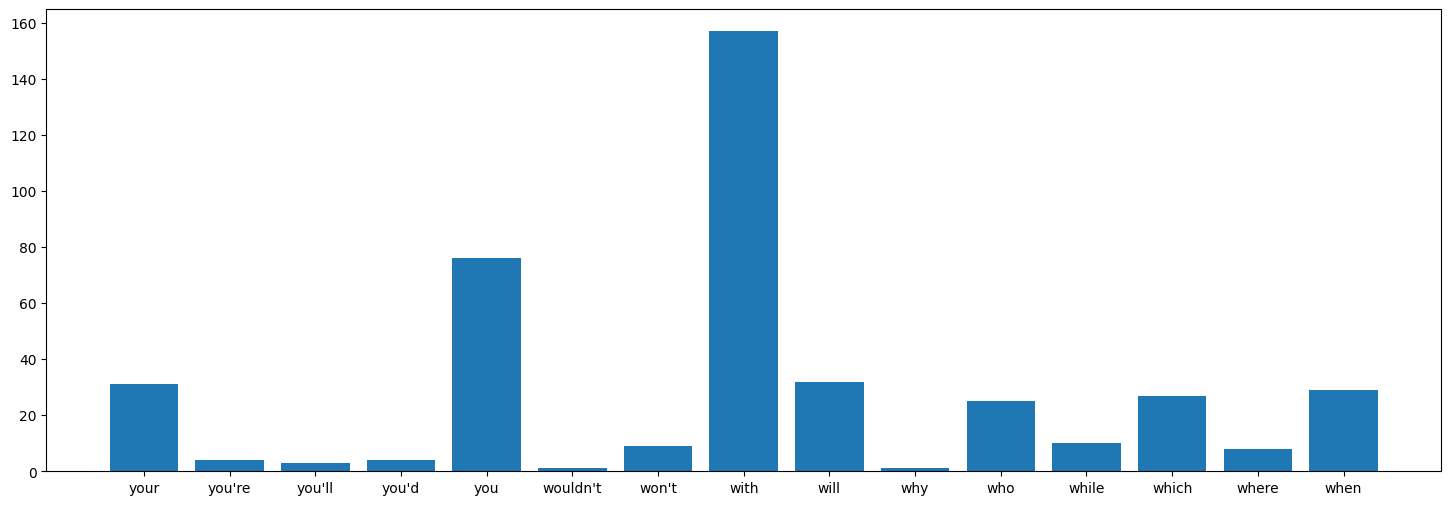

In [27]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

Проанализируем наличие стоп-слов в предложениях для негативного класса предложений

In [28]:
stop2=set(stopwords.words('english'))

corpus2=create_corpus('negative')

dic2= {}
for word in corpus2:
    if word in stop2:
        if word in dic2:
            dic2[word] += 1
        else:
            dic2[word] = 1

top2=sorted(dic.items(), key=lambda x:x[0],reverse=True)[:15]

<BarContainer object of 15 artists>

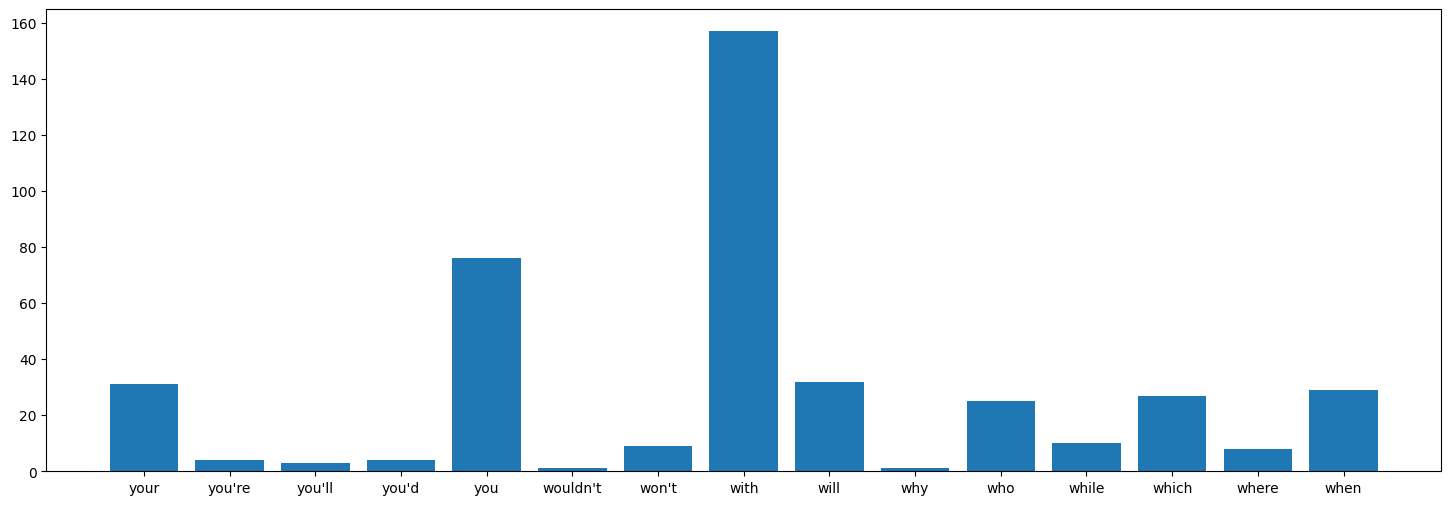

In [29]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top2)
plt.bar(x,y)

Попробуем также проанализировать bigram для всех классов

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

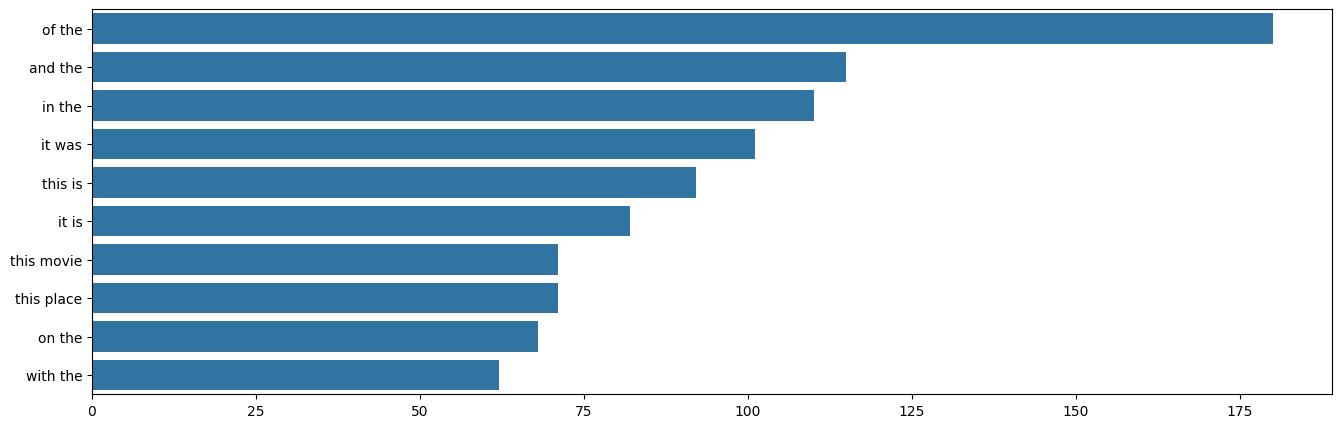

In [31]:
plt.figure(figsize=(16,5))
top_bigrams=get_top_bigrams(df_sent['sentence'])[:10]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x)

**Очистка данных**

In [32]:
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower().strip()
    # Удаление HTML-тегов
    text = re.sub('<[^>]+>', '', text)
    # Удаление URL
    text = re.sub(r'http\S+|www\S+|https\S+', '<URL>', text)
    # Удаление знаков препинания
    text = re.sub(r'[^\w\s]', '', text)
    # Удаление цифр
    text = re.sub(r'\d+', '', text)
    # Удаление пробелов
    text = text.strip()
    #удаление emoji
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

In [33]:
df_sent['sentence'] = df_sent['sentence'].apply(preprocess_text)

Токинизируем

In [34]:
nltk.download('punkt_tab')
df_sent['tokens'] = df_sent['sentence'].apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Как мы видели выше, предложения содержат много стоп-слов. Давайте избавимся от них.

In [35]:
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

In [36]:
df_sent['tokens'] = df_sent['tokens'].apply(remove_stopwords)

Лемматизация/стемминг.

In [37]:
lemm = WordNetLemmatizer()
df_sent['tokens'] = df_sent['tokens'].apply(lambda sentence: [lemm.lemmatize(word) for word in sentence])

Давайте посмотрим на повторяющиеся слова с помощью облака слов

In [38]:
def corpus_clouds(target):
  corpus_clouds=[]
  for x in df_sent[df_sent['sentiment'] == target]['tokens']:
    for i in x:
      corpus_clouds.append(i)
  return corpus_clouds

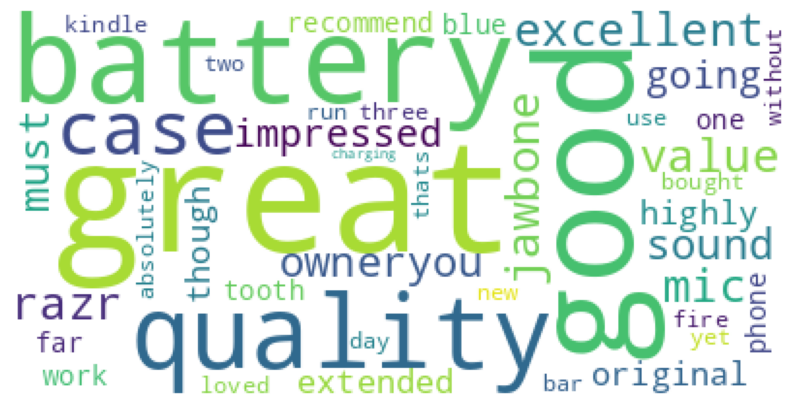

In [39]:
from wordcloud import WordCloud

plt.figure(figsize=(10,8))
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 80
                         ).generate(" ".join(corpus_clouds('positive')[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

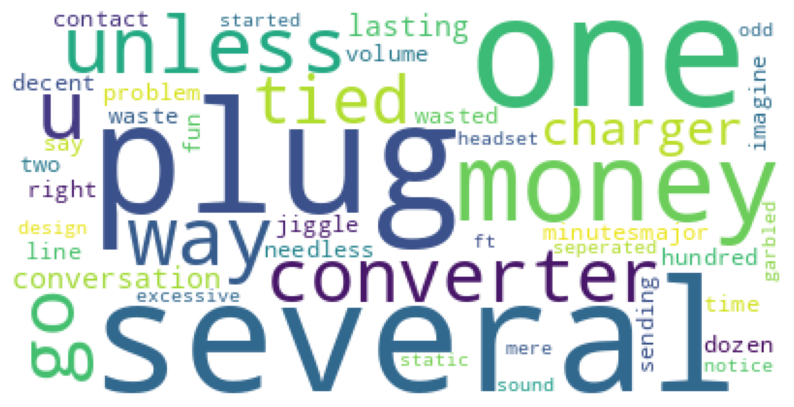

In [40]:
from wordcloud import WordCloud

plt.figure(figsize=(10,8))
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 80
                         ).generate(" ".join(corpus_clouds('negative')[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [41]:
df_sent['tokens'] = df_sent['tokens'].apply(lambda word: ' '.join(word))

Подготовим выборку для обучения и валидации

In [42]:
X = df_sent["tokens"]
y = df_sent["sentiment"]

In [43]:
le = LabelEncoder()
y = le.fit_transform(y)

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

# Наивный Байес

## BOW

In [45]:
nb_bow = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 1,))),
    ('classifier', MultinomialNB())
])

In [46]:
nb_bow.fit(X_train, y_train)

pred_train_nb_bow = nb_bow.predict(X_train)
pred_val_nb_bow = nb_bow.predict(X_val)

In [47]:
print('Train:', '\n')
print(classification_report(pred_train_nb_bow, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_nb_bow, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1320
           1       0.94      0.95      0.95      1312

    accuracy                           0.94      2632
   macro avg       0.94      0.94      0.94      2632
weighted avg       0.95      0.94      0.94      2632

Validation: 

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       305
           1       0.81      0.77      0.79       353

    accuracy                           0.78       658
   macro avg       0.78      0.78      0.78       658
weighted avg       0.78      0.78      0.78       658



AUC: 0.86


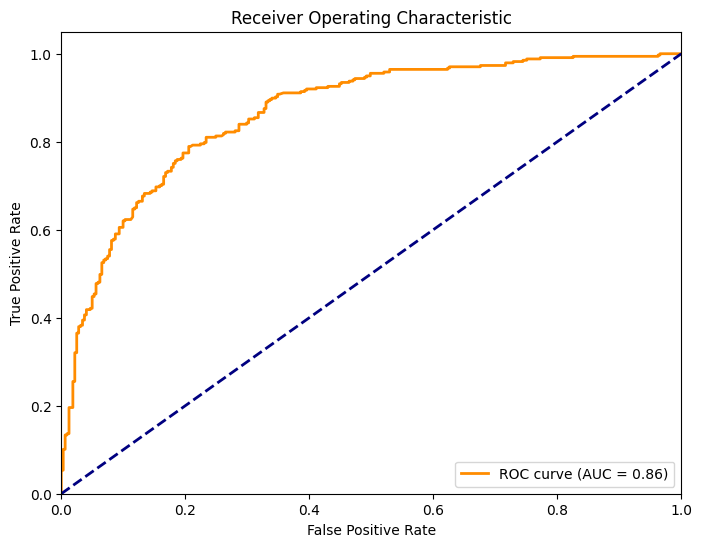

In [48]:
y_pred_proba = nb_bow.predict_proba(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Попробуем улучшить модель

In [49]:
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],  # ngram_range
    'vectorizer__max_df': [0.5, 0.75, 1.0],  # max_df
    'classifier__alpha': [0.1, 0.5, 1.0]  # alpha (сглаживание)
}

grid_search = GridSearchCV(nb_bow, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.1, 0.5, 1.0],
                         'vectorizer__max_df': [0.5, 0.75, 1.0],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='accuracy', verbose=2)

In [50]:
print("Best parameters:", grid_search.best_params_)

best_nb_bow = grid_search.best_estimator_


pred_train_nb_bow_best = best_nb_bow.predict(X_train)
pred_val_nb_bow_best = best_nb_bow.predict(X_val)

Best parameters: {'classifier__alpha': 1.0, 'vectorizer__max_df': 0.5, 'vectorizer__ngram_range': (1, 3)}


In [51]:
print('Train:', '\n')
print(classification_report(pred_train_nb_bow_best, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_nb_bow_best, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1295
           1       0.99      0.99      0.99      1337

    accuracy                           0.99      2632
   macro avg       0.99      0.99      0.99      2632
weighted avg       0.99      0.99      0.99      2632

Validation: 

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       297
           1       0.83      0.78      0.81       361

    accuracy                           0.79       658
   macro avg       0.79      0.79      0.79       658
weighted avg       0.80      0.79      0.79       658



## TF-IDF

In [52]:
nb_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer(min_df=3,
            ngram_range=(1, 2))),
    ('classifier', MultinomialNB())
])

In [53]:
nb_tfidf.fit(X_train, y_train)


pred_train_nb_tfidf = nb_tfidf.predict(X_train)
pred_val_nb_tfidf = nb_tfidf.predict(X_val)

In [54]:
print('Train:', '\n')
print(classification_report(pred_train_nb_tfidf, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_nb_tfidf, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1283
           1       0.90      0.89      0.90      1349

    accuracy                           0.89      2632
   macro avg       0.89      0.89      0.89      2632
weighted avg       0.89      0.89      0.89      2632

Validation: 

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       303
           1       0.78      0.74      0.76       355

    accuracy                           0.75       658
   macro avg       0.75      0.75      0.75       658
weighted avg       0.75      0.75      0.75       658



AUC: 0.84


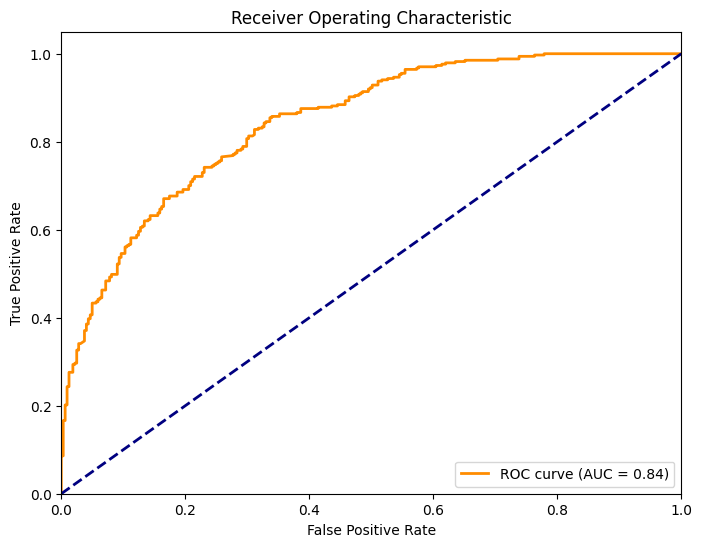

In [55]:
y_pred_proba = nb_tfidf.predict_proba(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Попробуем улучшить модель

In [56]:
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],  #ngram_range
    'vectorizer__min_df': [2, 3, 5],  # min_df
    'classifier__alpha': [0.1, 0.5, 1.0] #alpha
}

grid_search = GridSearchCV(nb_tfidf, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1) #verbose для информативности

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(min_df=3,
                                                        ngram_range=(1, 2))),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.1, 0.5, 1.0],
                         'vectorizer__min_df': [2, 3, 5],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='accuracy', verbose=2)

In [57]:
print("Best parameters:", grid_search.best_params_)

best_nb_tfidf = grid_search.best_estimator_


pred_train_nb_tfidf_best = best_nb_tfidf.predict(X_train)
pred_val_nb_tfidf_best = best_nb_tfidf.predict(X_val)

Best parameters: {'classifier__alpha': 1.0, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 3)}


In [58]:
print('Train:', '\n')
print(classification_report(pred_train_nb_tfidf_best, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_nb_tfidf_best, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1307
           1       0.92      0.93      0.92      1325

    accuracy                           0.92      2632
   macro avg       0.92      0.92      0.92      2632
weighted avg       0.92      0.92      0.92      2632

Validation: 

              precision    recall  f1-score   support

           0       0.74      0.78      0.76       303
           1       0.80      0.76      0.78       355

    accuracy                           0.77       658
   macro avg       0.77      0.77      0.77       658
weighted avg       0.77      0.77      0.77       658



AUC: 0.86


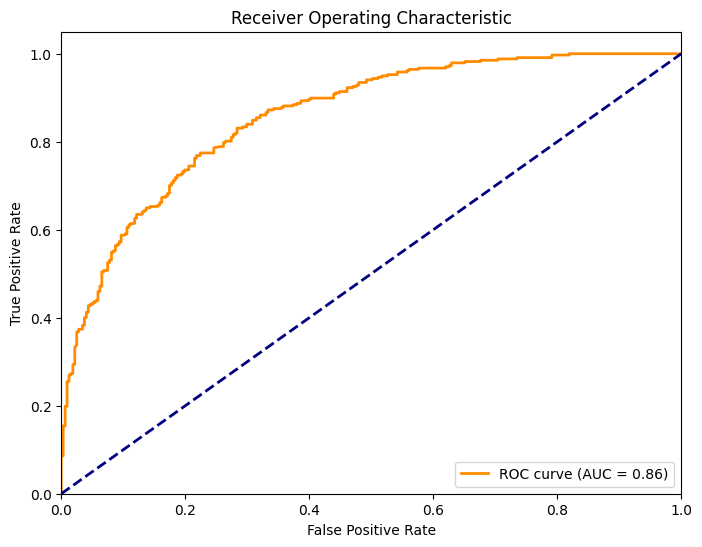

In [59]:
y_pred_proba = best_nb_tfidf.predict_proba(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Логистическая регрессия

## BOW

In [60]:
logr_bow = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2,))),
    ('classifier', LogisticRegression())
])

In [61]:
logr_bow.fit(X_train, y_train)

pred_train_logr_bow = logr_bow.predict(X_train)
pred_val_logr_bow = logr_bow.predict(X_val)

In [62]:
print('Train:', '\n')
print(classification_report(pred_train_logr_bow, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_logr_bow, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1300
           1       0.99      0.99      0.99      1332

    accuracy                           0.99      2632
   macro avg       0.99      0.99      0.99      2632
weighted avg       0.99      0.99      0.99      2632

Validation: 

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       339
           1       0.76      0.80      0.78       319

    accuracy                           0.78       658
   macro avg       0.78      0.78      0.78       658
weighted avg       0.78      0.78      0.78       658



AUC: 0.87


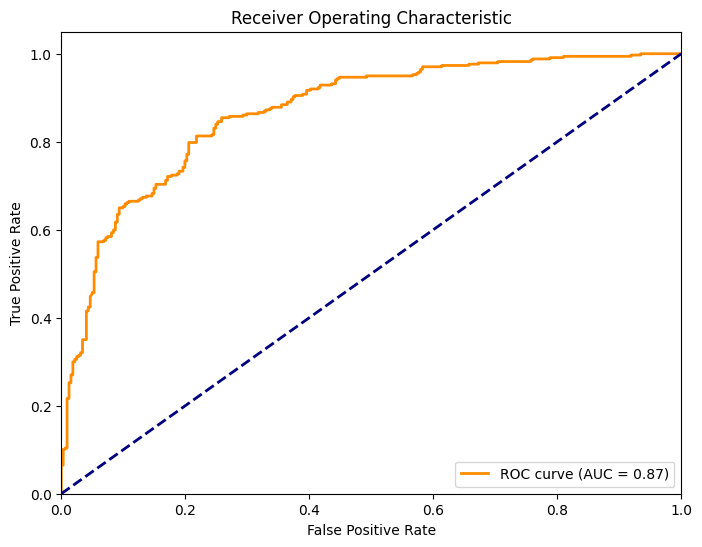

In [63]:
y_pred_proba = logr_bow.predict_proba(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Попробуем улучшить модель с помощью подбора параметров

In [64]:
logreg_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
    ('classifier', LogisticRegression())
])

In [65]:
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],  # ngram_range
    'vectorizer__max_df': [0.8, 1.0], #Максимальная доля документов, где встречается термин
    'classifier__C': [0.1, 1, 10, 100]  # Параметр регуляризации C
}

grid_search = GridSearchCV(logreg_pipeline, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1) #verbose для отображения процесса

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(ngram_range=(1, 2))),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10, 100],
                         'vectorizer__max_df': [0.8, 1.0],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=2)

In [66]:
print("Best parameters:", grid_search.best_params_)

best_logr_bow = grid_search.best_estimator_


pred_train_logr_bow_best = best_logr_bow.predict(X_train)
pred_val_logr_bow_best = best_logr_bow.predict(X_val)

Best parameters: {'classifier__C': 1, 'vectorizer__max_df': 0.8, 'vectorizer__ngram_range': (1, 2)}


In [67]:
print('Train:', '\n')
print(classification_report(pred_train_logr_bow_best, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_logr_bow_best, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1300
           1       0.99      0.99      0.99      1332

    accuracy                           0.99      2632
   macro avg       0.99      0.99      0.99      2632
weighted avg       0.99      0.99      0.99      2632

Validation: 

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       339
           1       0.76      0.80      0.78       319

    accuracy                           0.78       658
   macro avg       0.78      0.78      0.78       658
weighted avg       0.78      0.78      0.78       658



AUC: 0.87


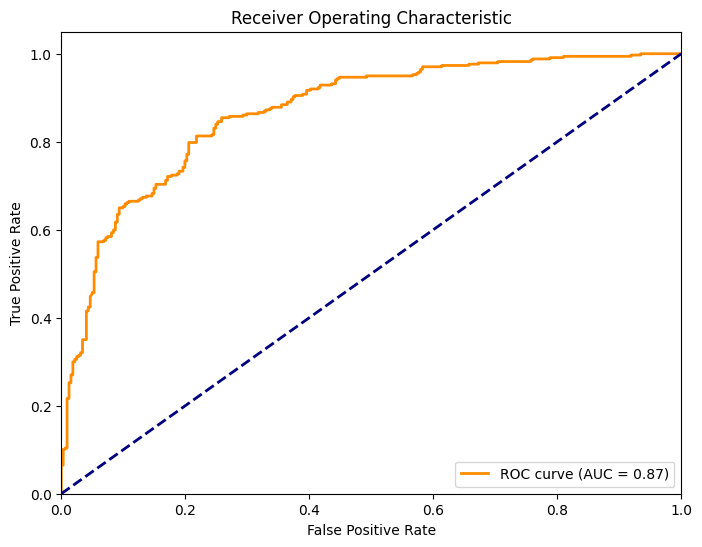

In [68]:
y_pred_proba = best_logr_bow.predict_proba(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## TD-IDF

In [69]:
logr_tfidf = Pipeline([
    ('vectorizer',TfidfVectorizer(min_df=3,
            ngram_range=(1, 2))),
    ('classifier', LogisticRegression())
])

In [70]:
logr_tfidf.fit(X_train, y_train)

pred_train_logr_tfidf_bow = logr_tfidf.predict(X_train)
pred_val_logr_tfidf_bow = logr_tfidf.predict(X_val)

In [71]:
print('Train:', '\n')
print(classification_report(pred_train_logr_tfidf_bow, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_logr_tfidf_bow, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1332
           1       0.89      0.91      0.90      1300

    accuracy                           0.90      2632
   macro avg       0.90      0.90      0.90      2632
weighted avg       0.90      0.90      0.90      2632

Validation: 

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       327
           1       0.75      0.76      0.75       331

    accuracy                           0.75       658
   macro avg       0.75      0.75      0.75       658
weighted avg       0.75      0.75      0.75       658



AUC: 0.84


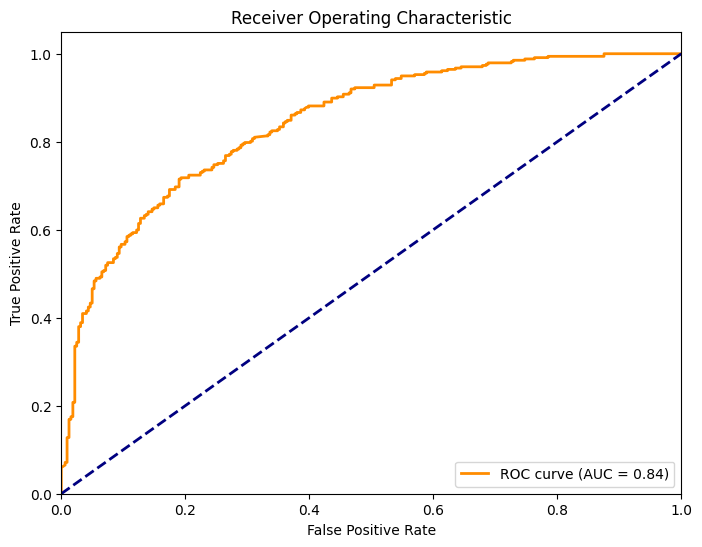

In [72]:
y_pred_proba = logr_tfidf.predict_proba(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Попробуем улучшить алгоритм

In [73]:
logreg_pipeline = Pipeline([
    ('vectorizer',TfidfVectorizer(min_df=3,
            ngram_range=(1, 2))),
    ('classifier', LogisticRegression())
])

In [74]:
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],  #ngram_range
    'vectorizer__min_df': [2, 3, 5],  # min_df
    'classifier__penalty': ['l1', 'l2'], #penalty
    'classifier__C': [0.1, 1, 10]  # C
}

grid_search = GridSearchCV(logreg_pipeline, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1) #verbose для отображения процесса

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
81 fits failed out of a total of 162.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(min_df=3,
                                                        ngram_range=(1, 2))),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__penalty': ['l1', 'l2'],
                         'vectorizer__min_df': [2, 3, 5],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='accuracy', verbose=2)

In [75]:
print("Best parameters:", grid_search.best_params_)

best_logr_tfidf = grid_search.best_estimator_


pred_train_logr_tfidf_best = best_logr_tfidf.predict(X_train)
pred_val_logr_tfidf_best = best_logr_tfidf.predict(X_val)

Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 1)}


In [76]:
print('Train:', '\n')
print(classification_report(pred_train_logr_tfidf_best, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_logr_tfidf_best, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1307
           1       0.97      0.97      0.97      1325

    accuracy                           0.97      2632
   macro avg       0.97      0.97      0.97      2632
weighted avg       0.97      0.97      0.97      2632

Validation: 

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       305
           1       0.78      0.75      0.76       353

    accuracy                           0.75       658
   macro avg       0.75      0.75      0.75       658
weighted avg       0.75      0.75      0.75       658



AUC: 0.84


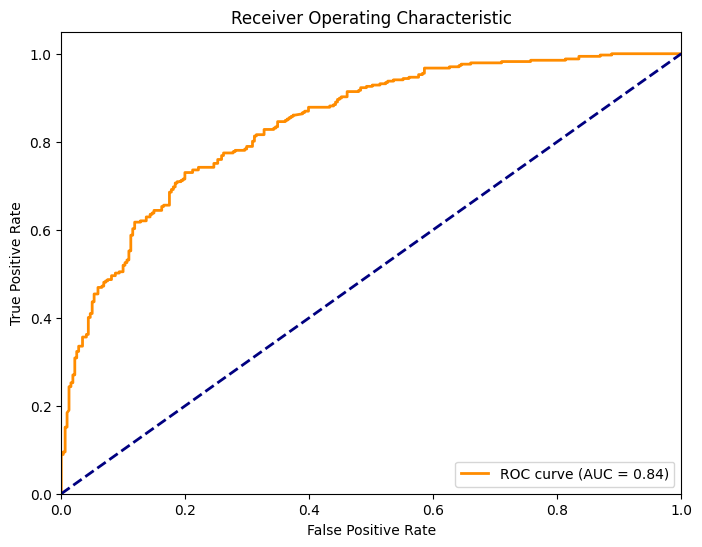

In [77]:
y_pred_proba = best_logr_tfidf.predict_proba(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# RandomForestClassifier

## BOW

In [78]:
rf_bow = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2,))),
    ('classifier', RandomForestClassifier(n_estimators=150))
])

In [79]:
rf_bow.fit(X_train, y_train)

pred_train_rf_bow = rf_bow.predict(X_train)
pred_val_rf_bow = rf_bow.predict(X_val)

In [80]:
print('Train:', '\n')
print(classification_report(pred_train_rf_bow, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_rf_bow, y_val))

Train: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1303
           1       1.00      1.00      1.00      1329

    accuracy                           1.00      2632
   macro avg       1.00      1.00      1.00      2632
weighted avg       1.00      1.00      1.00      2632

Validation: 

              precision    recall  f1-score   support

           0       0.87      0.71      0.78       396
           1       0.66      0.84      0.74       262

    accuracy                           0.76       658
   macro avg       0.76      0.78      0.76       658
weighted avg       0.79      0.76      0.76       658



AUC: 0.84


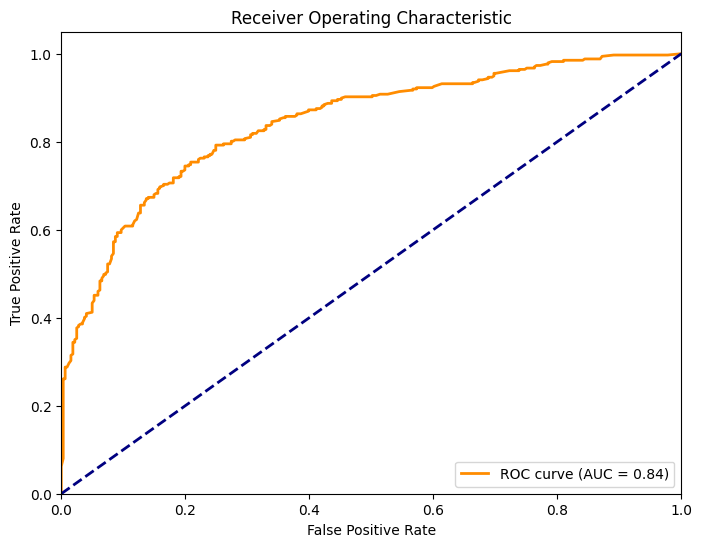

In [81]:
y_pred_proba = rf_bow.predict_proba(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Попробуем улучшить модель, подбирая гиперпараметры

In [82]:
def objective(trial):
    ngram_range = trial.suggest_categorical('vectorizer__ngram_range', [(1, 1), (1, 2), (1, 3)])
    max_df = trial.suggest_float('vectorizer__max_df', 0.7, 1.0)
    min_df = trial.suggest_int('vectorizer__min_df', 1, 3)
    n_estimators = trial.suggest_int('classifier__n_estimators', 50, 200)
    max_depth = trial.suggest_int('classifier__max_depth', 5, 30, log=True) #log=True
    min_samples_split = trial.suggest_int('classifier__min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('classifier__min_samples_leaf', 1, 4)


    rf = Pipeline([
        ('vectorizer', CountVectorizer(ngram_range=ngram_range, max_df=max_df, min_df=min_df)),
        ('classifier', RandomForestClassifier(n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              min_samples_split=min_samples_split,
                                              min_samples_leaf=min_samples_leaf,
                                              random_state=42))
    ])

    scores = cross_val_score(rf, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1) #n_jobs=-1
    return np.mean(scores)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)


[I 2025-02-16 14:08:36,253] A new study created in memory with name: no-name-728779b7-8b11-413f-b224-52ec0558444e
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3) which is of type tuple.
  warnings.warn(message)
[I 2025-02-16 14:08:37,106] Trial 0 finished with value: 0.7275869711837744 and parameters:

In [83]:
print("Best parameters:", study.best_params)
print("Best cross-validation score:", study.best_value)

Best parameters: {'vectorizer__ngram_range': (1, 2), 'vectorizer__max_df': 0.8268137937504394, 'vectorizer__min_df': 1, 'classifier__n_estimators': 105, 'classifier__max_depth': 20, 'classifier__min_samples_split': 8, 'classifier__min_samples_leaf': 1}
Best cross-validation score: 0.7500036796250074


In [84]:
# Разбираем best_params и передаем только параметры, относящиеся к RandomForestClassifier
rf_params = {k.split('__')[1]: v for k, v in study.best_params.items() if k.startswith('classifier')}

Используем лучшие гиперпараметры для предсказания

In [85]:
best_rf_bow = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1, 2,))),
    ('classifier', RandomForestClassifier(**rf_params, random_state=42))
])
best_rf_bow.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('classifier',
                 RandomForestClassifier(max_depth=20, min_samples_split=8,
                                        n_estimators=105, random_state=42))])

In [86]:
pred_train_rf_bow_best = best_rf_bow.predict(X_train)
pred_val_rf_bow_best = best_rf_bow.predict(X_val)

In [87]:
print('Train:', '\n')
print(classification_report(pred_train_rf_bow_best, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_rf_bow_best, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1323
           1       0.87      0.89      0.88      1309

    accuracy                           0.88      2632
   macro avg       0.88      0.88      0.88      2632
weighted avg       0.88      0.88      0.88      2632

Validation: 

              precision    recall  f1-score   support

           0       0.76      0.75      0.75       325
           1       0.76      0.77      0.76       333

    accuracy                           0.76       658
   macro avg       0.76      0.76      0.76       658
weighted avg       0.76      0.76      0.76       658



AUC: 0.83


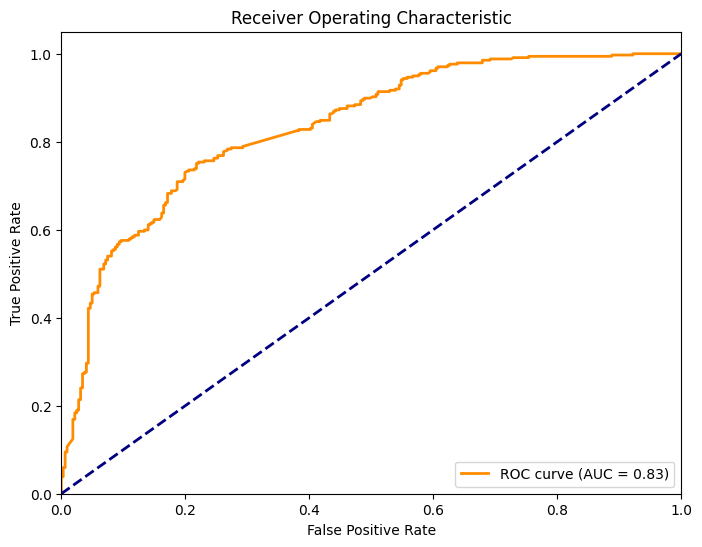

In [88]:
y_pred_proba = best_rf_bow.predict_proba(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## TD-IDF

In [89]:
rf_tdidf = Pipeline([
    ('vectorizer', TfidfVectorizer(min_df=3,
            ngram_range=(1, 2))),
    ('classifier', RandomForestClassifier(n_estimators=150))
])

In [90]:
rf_tdidf.fit(X_train, y_train)

pred_train_rf_tdidf = rf_tdidf.predict(X_train)
pred_val_rf_tdidf = rf_tdidf.predict(X_val)

In [91]:
print('Train:', '\n')
print(classification_report(pred_train_rf_tdidf, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_rf_tdidf, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1307
           1       0.99      0.99      0.99      1325

    accuracy                           0.99      2632
   macro avg       0.99      0.99      0.99      2632
weighted avg       0.99      0.99      0.99      2632

Validation: 

              precision    recall  f1-score   support

           0       0.80      0.74      0.77       347
           1       0.73      0.79      0.76       311

    accuracy                           0.77       658
   macro avg       0.77      0.77      0.77       658
weighted avg       0.77      0.77      0.77       658



AUC: 0.84


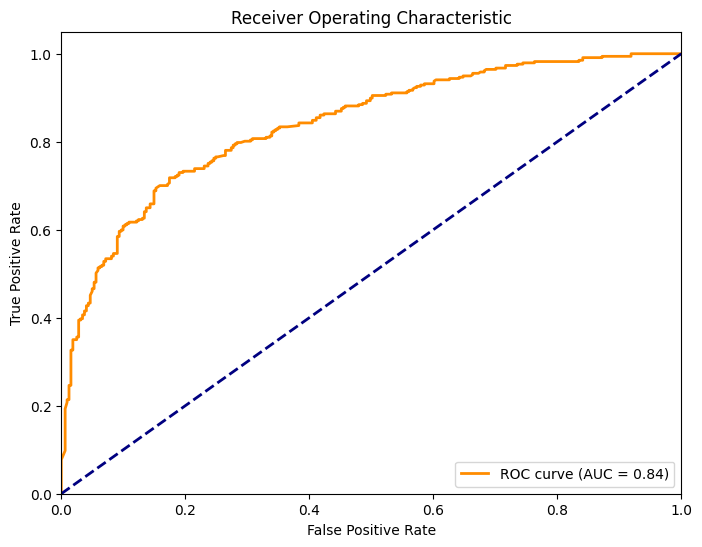

In [92]:
y_pred_proba = rf_tdidf.predict_proba(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Попробуем улучшить модель, подбирая гиперпараметры

In [93]:
def objective(trial):
    ngram_range = trial.suggest_categorical('vectorizer__ngram_range', [(1, 1), (1, 2), (1, 3)])
    max_df = trial.suggest_float('vectorizer__max_df', 0.7, 1.0)
    min_df = trial.suggest_int('vectorizer__min_df', 1, 3)
    n_estimators = trial.suggest_int('classifier__n_estimators', 50, 200)
    max_depth = trial.suggest_int('classifier__max_depth', 5, 30, log=True) #log=True
    min_samples_split = trial.suggest_int('classifier__min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('classifier__min_samples_leaf', 1, 4)


    rf = Pipeline([
        ('vectorizer', TfidfVectorizer(min_df=3,
            ngram_range=(1, 2))),
        ('classifier', RandomForestClassifier(n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              min_samples_split=min_samples_split,
                                              min_samples_leaf=min_samples_leaf,
                                              random_state=42))
    ])

    scores = cross_val_score(rf, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1) #n_jobs=-1
    return np.mean(scores)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-02-16 14:08:49,820] A new study created in memory with name: no-name-581d36ff-b17a-40d5-9059-f9826ba66d4c
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3) which is of type tuple.
  warnings.warn(message)
[I 2025-02-16 14:08:50,885] Trial 0 finished with value: 0.7017404193387238 and parameters:

In [94]:
print("Best parameters:", study.best_params)
print("Best cross-validation score:", study.best_value)

Best parameters: {'vectorizer__ngram_range': (1, 1), 'vectorizer__max_df': 0.7715839927997769, 'vectorizer__min_df': 3, 'classifier__n_estimators': 192, 'classifier__max_depth': 24, 'classifier__min_samples_split': 9, 'classifier__min_samples_leaf': 3}
Best cross-validation score: 0.7329124708119158


In [95]:
# Разбираем best_params и передаем только параметры, относящиеся к RandomForestClassifier
rf_params = {k.split('__')[1]: v for k, v in study.best_params.items() if k.startswith('classifier')}

Используем лучшие гиперпараметры для предсказания

In [96]:
best_rf_tfidf = Pipeline([
    ('vectorizer',  TfidfVectorizer(min_df=3,
            ngram_range=(1, 2))),
    ('classifier', RandomForestClassifier(**rf_params, random_state=42))
])
best_rf_tfidf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(min_df=3, ngram_range=(1, 2))),
                ('classifier',
                 RandomForestClassifier(max_depth=24, min_samples_leaf=3,
                                        min_samples_split=9, n_estimators=192,
                                        random_state=42))])

In [97]:
pred_train_rf_tfidf_best = best_rf_tfidf.predict(X_train)
pred_val_rf_tfidf_best = best_rf_tfidf.predict(X_val)

In [98]:
print('Train:', '\n')
print(classification_report(pred_train_rf_tfidf_best, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_rf_tfidf_best, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1541
           1       0.72      0.88      0.79      1091

    accuracy                           0.81      2632
   macro avg       0.81      0.82      0.81      2632
weighted avg       0.82      0.81      0.81      2632

Validation: 

              precision    recall  f1-score   support

           0       0.83      0.69      0.76       388
           1       0.64      0.80      0.71       270

    accuracy                           0.74       658
   macro avg       0.74      0.75      0.74       658
weighted avg       0.76      0.74      0.74       658



AUC: 0.81


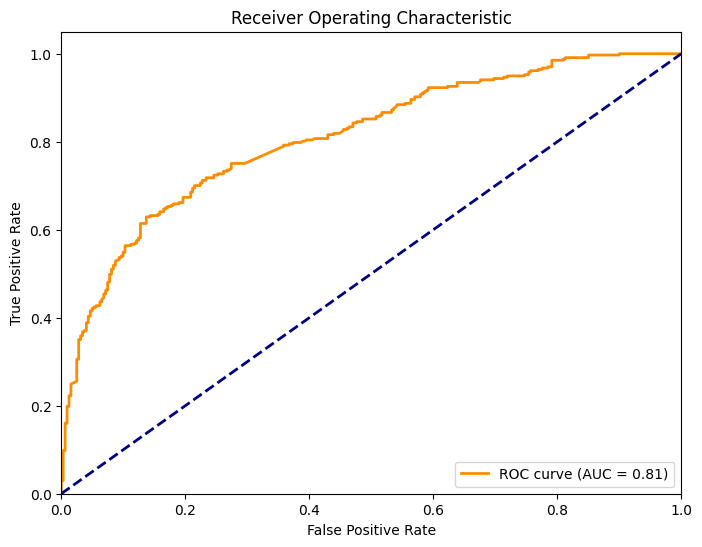

In [99]:
y_pred_proba = best_rf_tfidf.predict_proba(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# SVM

## BOW

In [100]:
svm_bow = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2,))),
    ('classifier', SVC(kernel='linear', C=1, probability=True))
])
svm_bow.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('classifier', SVC(C=1, kernel='linear', probability=True))])

In [101]:
pred_train_svm_bow = svm_bow.predict(X_train)
pred_val_svm_bow = svm_bow.predict(X_val)

In [102]:
print('Train:', '\n')
print(classification_report(pred_train_svm_bow, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_svm_bow, y_val))

Train: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1300
           1       1.00      1.00      1.00      1332

    accuracy                           1.00      2632
   macro avg       1.00      1.00      1.00      2632
weighted avg       1.00      1.00      1.00      2632

Validation: 

              precision    recall  f1-score   support

           0       0.79      0.76      0.77       335
           1       0.76      0.79      0.77       323

    accuracy                           0.77       658
   macro avg       0.77      0.77      0.77       658
weighted avg       0.77      0.77      0.77       658



AUC: 0.87


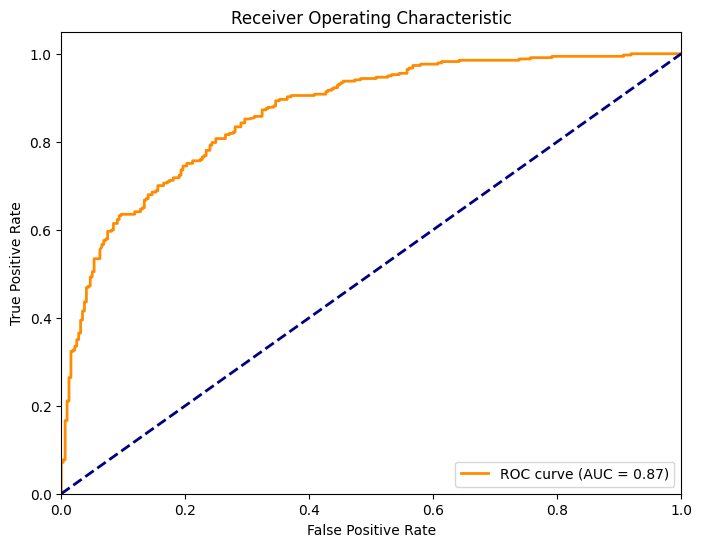

In [103]:
y_pred_proba = svm_bow.predict_proba(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Давайте попробуем улучшить модель, подобрав гиперпараметры

In [104]:
svm_bow_best = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
    ('classifier', SVC(probability=True))
])

In [105]:
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.01, 0.001],
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

grid = GridSearchCV(svm_bow_best, param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=linear, vectorizer__ngram_range=(1, 1); total time=   1.7s
[CV] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=linear, vectorizer__ngram_range=(1, 1); total time=   1.6s
[CV] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=linear, vectorizer__ngram_range=(1, 1); total time=   2.1s
[CV] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=linear, vectorizer__ngram_range=(1, 1); total time=   2.0s
[CV] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=linear, vectorizer__ngram_range=(1, 1); total time=   2.2s
[CV] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=linear, vectorizer__ngram_range=(1, 2); total time=   2.6s
[CV] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=linear, vectorizer__ngram_range=(1, 2); total time=   2.4s
[CV] END classifier__C=0.1, classifier__gamma=1,

GridSearchCV(estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(ngram_range=(1, 2))),
                                       ('classifier', SVC(probability=True))]),
             param_grid={'classifier__C': [0.1, 1, 10, 100],
                         'classifier__gamma': [1, 0.1, 0.01, 0.001],
                         'classifier__kernel': ['linear', 'poly', 'rbf',
                                                'sigmoid'],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             verbose=2)

In [106]:
print("Best parameters:", grid.best_params_)

Best parameters: {'classifier__C': 10, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf', 'vectorizer__ngram_range': (1, 2)}


Обучим модель с лучшими гиперпараметрами

In [107]:
best_model_svm_bow = grid.best_estimator_
pred_train_svm_bow_best = best_model_svm_bow.predict(X_train)
pred_val_svm_bow_best = best_model_svm_bow.predict(X_val)

In [108]:
print('Train:', '\n')
print(classification_report(pred_train_svm_bow_best, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_svm_bow_best, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1304
           1       0.98      0.99      0.99      1328

    accuracy                           0.99      2632
   macro avg       0.99      0.99      0.99      2632
weighted avg       0.99      0.99      0.99      2632

Validation: 

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       360
           1       0.73      0.83      0.77       298

    accuracy                           0.78       658
   macro avg       0.78      0.79      0.78       658
weighted avg       0.79      0.78      0.78       658



## TD-IDF

In [109]:
svm_tdidf = Pipeline([
    ('vectorizer', TfidfVectorizer(min_df=3,
            ngram_range=(1, 2))),
    ('classifier',  SVC(kernel='linear', C=1))
])
svm_tdidf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(min_df=3, ngram_range=(1, 2))),
                ('classifier', SVC(C=1, kernel='linear'))])

In [110]:
pred_train_svm_tdidf = svm_tdidf.predict(X_train)
pred_val_svm_tdidf = svm_tdidf.predict(X_val)

In [111]:
print('Train:', '\n')
print(classification_report(pred_train_svm_tdidf, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_svm_tdidf, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1326
           1       0.90      0.92      0.91      1306

    accuracy                           0.91      2632
   macro avg       0.91      0.91      0.91      2632
weighted avg       0.91      0.91      0.91      2632

Validation: 

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       321
           1       0.77      0.77      0.77       337

    accuracy                           0.76       658
   macro avg       0.76      0.76      0.76       658
weighted avg       0.76      0.76      0.76       658



Давайте попробуем улучшить модель, подобрав гиперпараметры

In [112]:
svm_tfidf_best = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
    ('classifier', SVC())
])

In [113]:
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.01, 0.001],
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

grid = GridSearchCV(svm_tfidf_best, param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=linear, vectorizer__ngram_range=(1, 1); total time=   0.5s
[CV] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=linear, vectorizer__ngram_range=(1, 1); total time=   0.4s
[CV] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=linear, vectorizer__ngram_range=(1, 1); total time=   0.4s
[CV] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=linear, vectorizer__ngram_range=(1, 1); total time=   0.4s
[CV] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=linear, vectorizer__ngram_range=(1, 1); total time=   0.4s
[CV] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=linear, vectorizer__ngram_range=(1, 2); total time=   0.6s
[CV] END classifier__C=0.1, classifier__gamma=1, classifier__kernel=linear, vectorizer__ngram_range=(1, 2); total time=   0.6s
[CV] END classifier__C=0.1, classifier__gamma=1,

GridSearchCV(estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(ngram_range=(1, 2))),
                                       ('classifier', SVC())]),
             param_grid={'classifier__C': [0.1, 1, 10, 100],
                         'classifier__gamma': [1, 0.1, 0.01, 0.001],
                         'classifier__kernel': ['linear', 'poly', 'rbf',
                                                'sigmoid'],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             verbose=2)

In [114]:
print("Best parameters:", grid.best_params_)

Best parameters: {'classifier__C': 10, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf', 'vectorizer__ngram_range': (1, 2)}


Обучим модель с лучшими гипепараметрами

In [115]:
best_model_svm_tfidf = grid.best_estimator_
pred_train_svm_tfidf_best = best_model_svm_tfidf.predict(X_train)
pred_val_svm_tfidf_best = best_model_svm_tfidf.predict(X_val)

In [116]:
print('Train:', '\n')
print(classification_report(pred_train_svm_tfidf_best, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_svm_tfidf_best, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1304
           1       0.98      0.99      0.99      1328

    accuracy                           0.99      2632
   macro avg       0.99      0.99      0.99      2632
weighted avg       0.99      0.99      0.99      2632

Validation: 

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       360
           1       0.73      0.83      0.77       298

    accuracy                           0.78       658
   macro avg       0.78      0.79      0.78       658
weighted avg       0.79      0.78      0.78       658



# Метрики качества всех моделей

##**1. Наивный Байес:**

- **BOW**

In [119]:
print('Train:', '\n')
print(classification_report(pred_train_nb_bow, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_nb_bow, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1320
           1       0.94      0.95      0.95      1312

    accuracy                           0.94      2632
   macro avg       0.94      0.94      0.94      2632
weighted avg       0.95      0.94      0.94      2632

Validation: 

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       305
           1       0.81      0.77      0.79       353

    accuracy                           0.78       658
   macro avg       0.78      0.78      0.78       658
weighted avg       0.78      0.78      0.78       658



- **BOW с подобранными параметрами**

In [120]:
print('Train:', '\n')
print(classification_report(pred_train_nb_bow_best, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_nb_bow_best, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1295
           1       0.99      0.99      0.99      1337

    accuracy                           0.99      2632
   macro avg       0.99      0.99      0.99      2632
weighted avg       0.99      0.99      0.99      2632

Validation: 

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       297
           1       0.83      0.78      0.81       361

    accuracy                           0.79       658
   macro avg       0.79      0.79      0.79       658
weighted avg       0.80      0.79      0.79       658



- **TF-IDF**

In [121]:
print('Train:', '\n')
print(classification_report(pred_train_nb_tfidf, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_nb_tfidf, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1283
           1       0.90      0.89      0.90      1349

    accuracy                           0.89      2632
   macro avg       0.89      0.89      0.89      2632
weighted avg       0.89      0.89      0.89      2632

Validation: 

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       303
           1       0.78      0.74      0.76       355

    accuracy                           0.75       658
   macro avg       0.75      0.75      0.75       658
weighted avg       0.75      0.75      0.75       658



- **TF-IDF с подобранными параметрами**

In [122]:
print('Train:', '\n')
print(classification_report(pred_train_nb_tfidf_best, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_nb_tfidf_best, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1307
           1       0.92      0.93      0.92      1325

    accuracy                           0.92      2632
   macro avg       0.92      0.92      0.92      2632
weighted avg       0.92      0.92      0.92      2632

Validation: 

              precision    recall  f1-score   support

           0       0.74      0.78      0.76       303
           1       0.80      0.76      0.78       355

    accuracy                           0.77       658
   macro avg       0.77      0.77      0.77       658
weighted avg       0.77      0.77      0.77       658



## **2. Логистическая регрессия:**

- **BOW**

In [123]:
print('Train:', '\n')
print(classification_report(pred_train_logr_bow, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_logr_bow, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1300
           1       0.99      0.99      0.99      1332

    accuracy                           0.99      2632
   macro avg       0.99      0.99      0.99      2632
weighted avg       0.99      0.99      0.99      2632

Validation: 

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       339
           1       0.76      0.80      0.78       319

    accuracy                           0.78       658
   macro avg       0.78      0.78      0.78       658
weighted avg       0.78      0.78      0.78       658



- **BOW с подобранными параметрами**

In [124]:
print('Train:', '\n')
print(classification_report(pred_train_logr_bow_best, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_logr_bow_best, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1300
           1       0.99      0.99      0.99      1332

    accuracy                           0.99      2632
   macro avg       0.99      0.99      0.99      2632
weighted avg       0.99      0.99      0.99      2632

Validation: 

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       339
           1       0.76      0.80      0.78       319

    accuracy                           0.78       658
   macro avg       0.78      0.78      0.78       658
weighted avg       0.78      0.78      0.78       658



- **TF-IDF**

In [125]:
print('Train:', '\n')
print(classification_report(pred_train_logr_tfidf_bow, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_logr_tfidf_bow, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1332
           1       0.89      0.91      0.90      1300

    accuracy                           0.90      2632
   macro avg       0.90      0.90      0.90      2632
weighted avg       0.90      0.90      0.90      2632

Validation: 

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       327
           1       0.75      0.76      0.75       331

    accuracy                           0.75       658
   macro avg       0.75      0.75      0.75       658
weighted avg       0.75      0.75      0.75       658



- **TF-IDF с подобранными параметрами**

In [126]:
print('Train:', '\n')
print(classification_report(pred_train_logr_tfidf_best, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_logr_tfidf_best, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1307
           1       0.97      0.97      0.97      1325

    accuracy                           0.97      2632
   macro avg       0.97      0.97      0.97      2632
weighted avg       0.97      0.97      0.97      2632

Validation: 

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       305
           1       0.78      0.75      0.76       353

    accuracy                           0.75       658
   macro avg       0.75      0.75      0.75       658
weighted avg       0.75      0.75      0.75       658



##**3. Случайный лес:**

- **BOW**

In [127]:
print('Train:', '\n')
print(classification_report(pred_train_rf_bow, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_rf_bow, y_val))

Train: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1303
           1       1.00      1.00      1.00      1329

    accuracy                           1.00      2632
   macro avg       1.00      1.00      1.00      2632
weighted avg       1.00      1.00      1.00      2632

Validation: 

              precision    recall  f1-score   support

           0       0.87      0.71      0.78       396
           1       0.66      0.84      0.74       262

    accuracy                           0.76       658
   macro avg       0.76      0.78      0.76       658
weighted avg       0.79      0.76      0.76       658



- **BOW с подобранными параметрами**

In [128]:
print('Train:', '\n')
print(classification_report(pred_train_rf_bow_best, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_rf_bow_best, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1323
           1       0.87      0.89      0.88      1309

    accuracy                           0.88      2632
   macro avg       0.88      0.88      0.88      2632
weighted avg       0.88      0.88      0.88      2632

Validation: 

              precision    recall  f1-score   support

           0       0.76      0.75      0.75       325
           1       0.76      0.77      0.76       333

    accuracy                           0.76       658
   macro avg       0.76      0.76      0.76       658
weighted avg       0.76      0.76      0.76       658



- **TF-IDF**

In [129]:
print('Train:', '\n')
print(classification_report(pred_train_rf_tdidf, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_rf_tdidf, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1307
           1       0.99      0.99      0.99      1325

    accuracy                           0.99      2632
   macro avg       0.99      0.99      0.99      2632
weighted avg       0.99      0.99      0.99      2632

Validation: 

              precision    recall  f1-score   support

           0       0.80      0.74      0.77       347
           1       0.73      0.79      0.76       311

    accuracy                           0.77       658
   macro avg       0.77      0.77      0.77       658
weighted avg       0.77      0.77      0.77       658



- **TF-IDF с подобранными параметрами**

In [130]:
print('Train:', '\n')
print(classification_report(pred_train_rf_tfidf_best, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_rf_tfidf_best, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1541
           1       0.72      0.88      0.79      1091

    accuracy                           0.81      2632
   macro avg       0.81      0.82      0.81      2632
weighted avg       0.82      0.81      0.81      2632

Validation: 

              precision    recall  f1-score   support

           0       0.83      0.69      0.76       388
           1       0.64      0.80      0.71       270

    accuracy                           0.74       658
   macro avg       0.74      0.75      0.74       658
weighted avg       0.76      0.74      0.74       658



## **4. SVM:**

- **BOW**

In [131]:
print('Train:', '\n')
print(classification_report(pred_train_svm_bow, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_svm_bow, y_val))

Train: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1300
           1       1.00      1.00      1.00      1332

    accuracy                           1.00      2632
   macro avg       1.00      1.00      1.00      2632
weighted avg       1.00      1.00      1.00      2632

Validation: 

              precision    recall  f1-score   support

           0       0.79      0.76      0.77       335
           1       0.76      0.79      0.77       323

    accuracy                           0.77       658
   macro avg       0.77      0.77      0.77       658
weighted avg       0.77      0.77      0.77       658



- **BOW с подобранными параметрами**

In [132]:
print('Train:', '\n')
print(classification_report(pred_train_svm_bow_best, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_svm_bow_best, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1304
           1       0.98      0.99      0.99      1328

    accuracy                           0.99      2632
   macro avg       0.99      0.99      0.99      2632
weighted avg       0.99      0.99      0.99      2632

Validation: 

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       360
           1       0.73      0.83      0.77       298

    accuracy                           0.78       658
   macro avg       0.78      0.79      0.78       658
weighted avg       0.79      0.78      0.78       658



- **TF-IDF**

In [133]:
print('Train:', '\n')
print(classification_report(pred_train_svm_tdidf, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_svm_tdidf, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1326
           1       0.90      0.92      0.91      1306

    accuracy                           0.91      2632
   macro avg       0.91      0.91      0.91      2632
weighted avg       0.91      0.91      0.91      2632

Validation: 

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       321
           1       0.77      0.77      0.77       337

    accuracy                           0.76       658
   macro avg       0.76      0.76      0.76       658
weighted avg       0.76      0.76      0.76       658



- **TF-IDF с подобранными параметрами**

In [134]:
print('Train:', '\n')
print(classification_report(pred_train_svm_tfidf_best, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_svm_tfidf_best, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1304
           1       0.98      0.99      0.99      1328

    accuracy                           0.99      2632
   macro avg       0.99      0.99      0.99      2632
weighted avg       0.99      0.99      0.99      2632

Validation: 

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       360
           1       0.73      0.83      0.77       298

    accuracy                           0.78       658
   macro avg       0.78      0.79      0.78       658
weighted avg       0.79      0.78      0.78       658



# Лучшая модель - Наивный Байес (BOW, подобранные параметры)

In [135]:
print('Train:', '\n')
print(classification_report(pred_train_nb_bow_best, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_nb_bow_best, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1295
           1       0.99      0.99      0.99      1337

    accuracy                           0.99      2632
   macro avg       0.99      0.99      0.99      2632
weighted avg       0.99      0.99      0.99      2632

Validation: 

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       297
           1       0.83      0.78      0.81       361

    accuracy                           0.79       658
   macro avg       0.79      0.79      0.79       658
weighted avg       0.80      0.79      0.79       658

